# Description of the project

Customers began to leave Beta-Bank. Every month. A little, but noticeable. Bank marketers considered: to save
current customers are cheaper than acquiring new ones. <br />
<br />
It is necessary to predict whether the client will leave the bank in the near future or not. You are provided with historical behavioral data
customers and termination of agreements with the bank. <br />
<br />
It is necessary to build a model with an extremely large value of the F1-measure. You need to bring the metric to 0.59 and check it (F1-measure)
on the test set. Also additionally calculate the AUC-ROC and compare its value with the F1-measure.

# Description of data

Signs: <br />
- RowNumber - row index in the data
- CustomerId — unique customer identifier
- Surname - surname
- CreditScore - credit rating
- Geography - country of residence
- Gender - gender
- Age - age
- Tenure - the amount of real estate the client has
- Balance - account balance
- NumOfProducts - the number of bank products used by the client
- HasCrCard - the presence of a credit card
- IsActiveMember - client activity
- EstimatedSalary - estimated salary

Target sign: <br />
- Exited - the fact that the client left

# Import data files, study general information

In [1]:
import pandas as pd
from IPython.display import display


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
#df = pd.read_csv('Churn.csv', sep=',')
df = pd.read_csv('/datasets/Churn.csv', sep=',')
display(df)
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


# Data preparation

Get rid of unnecessary features

In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

There are gaps in the Tenure feature, 9 in total. Let's get rid of them

In [4]:
index = df.query('Tenure == "NaN"').index
df = df.drop(index).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   float64
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 781.4+ KB


Let's transform categorical features into quantitative ones

In [5]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [6]:
print(df_ohe.dtypes)

CreditScore            int64
Age                    int64
Tenure               float64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Male            uint8
dtype: object


Divide the samples into sets with features and a target feature

In [7]:
features = df_ohe.drop(['Exited'], axis=1)
target = df_ohe['Exited']

Let's divide the data into three samples: train, validation test in the ratio `3 : 1 : 1`

In [8]:
features_train, features_valid = train_test_split(features, test_size=0.20, random_state=12345)
features_train, features_test = train_test_split(features_train, test_size=0.25, random_state=12345)

target_train, target_valid = train_test_split(target, test_size=0.20, random_state=12345)
target_train, target_test = train_test_split(target_train, test_size=0.25, random_state=12345)

print(features.shape)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(9091, 11)
(5454, 11)
(1819, 11)
(1818, 11)


Scale features

In [9]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


# Exploring models without class imbalance

## Model: decision tree

In [10]:
for depth in range(1, 12):
    
    model_dec_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_dec_tree.fit(features_train, target_train)
    predicted_valid = model_dec_tree.predict(features_valid)
    result = accuracy_score(target_valid, predicted_valid)
    
    print('max_depth =', depth)
    print("F1:", f1_score(target_valid, predicted_valid))
    print()

max_depth = 1
F1: 0.0

max_depth = 2
F1: 0.5234248788368336

max_depth = 3
F1: 0.3907563025210084

max_depth = 4
F1: 0.41493775933609955

max_depth = 5
F1: 0.5831960461285008

max_depth = 6
F1: 0.5437956204379562

max_depth = 7
F1: 0.585209003215434

max_depth = 8
F1: 0.5513866231647635

max_depth = 9
F1: 0.5942684766214177

max_depth = 10
F1: 0.5147286821705426

max_depth = 11
F1: 0.5171898355754858



Retrain the model with better parameters

In [11]:
model_dec_tree = DecisionTreeClassifier(random_state=12345, max_depth=9) 
model_dec_tree.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=9, random_state=12345)

## Model: random forest

In [12]:
for est in range(10, 102, 5):
    
    model_ran_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=9)
    model_ran_forest.fit(features_train, target_train)
    predicted_valid = model_ran_forest.predict(features_valid)
    
    print('n_estimators =', est)
    print("F1:", f1_score(target_valid, predicted_valid))
    print()

n_estimators = 10
F1: 0.5236363636363636

n_estimators = 15
F1: 0.5342960288808665

n_estimators = 20
F1: 0.5352622061482822

n_estimators = 25
F1: 0.5280289330922242

n_estimators = 30
F1: 0.5287769784172661

n_estimators = 35
F1: 0.5376344086021504

n_estimators = 40
F1: 0.5342960288808665

n_estimators = 45
F1: 0.5431654676258992

n_estimators = 50
F1: 0.5352622061482822

n_estimators = 55
F1: 0.5352622061482822

n_estimators = 60
F1: 0.5263157894736842

n_estimators = 65
F1: 0.5335753176043557

n_estimators = 70
F1: 0.5369369369369369

n_estimators = 75
F1: 0.5379061371841154

n_estimators = 80
F1: 0.5405405405405406

n_estimators = 85
F1: 0.5405405405405406

n_estimators = 90
F1: 0.5335753176043557

n_estimators = 95
F1: 0.5362318840579711

n_estimators = 100
F1: 0.5335753176043557



Retrain the model with better parameters

In [13]:
model_ran_forest = RandomForestClassifier(random_state=12345, n_estimators=45, max_depth=9)
model_ran_forest.fit(features_train, target_train) 

RandomForestClassifier(max_depth=9, n_estimators=45, random_state=12345)

## Model: logistic regression

In [14]:
model_log_reg = LogisticRegression(random_state=12345, solver='liblinear')
model_log_reg.fit(features_train, target_train)
predicted_valid = model_log_reg.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.32926829268292684


## Checking models on a test set

In [15]:
predicted_test = model_dec_tree.predict(features_test)

print("Decision tree model on the test sample:")
print("F1:", f1_score(target_test, predicted_test))

probabilities_test = model_dec_tree.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr_tree, tpr_tree, thresholds_tree = roc_curve(target_test, probabilities_one_test) 
print('auc_roc:', roc_auc_score(target_test, probabilities_one_test))
print()
#//
#//
predicted_test = model_ran_forest.predict(features_test)

print("Random forest model on a test sample:")
print("F1:", f1_score(target_test, predicted_test))

probabilities_test = model_ran_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr_for, tpr_for, thresholds_for = roc_curve(target_test, probabilities_one_test) 
print('auc_roc:', roc_auc_score(target_test, probabilities_one_test))
print()
#//
#//
predicted_test = model_log_reg.predict(features_test)

print("Logistic regression model on a test sample:")
print("F1:", f1_score(target_test, predicted_test))

probabilities_test = model_log_reg.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr_reg, tpr_reg, thresholds_reg = roc_curve(target_test, probabilities_one_test) 
print('auc_roc:', roc_auc_score(target_test, probabilities_one_test))
print()

Модель решающего дерева на тестовой выборке выборке:
F1: 0.557427258805513
auc_roc: 0.8062753089765011

Модель случайного леса на тестовой выборке выборке:
F1: 0.5272727272727272
auc_roc: 0.8479692604133737

Модель логистической регрессии на тестовой выборке выборке:
F1: 0.3004115226337448
auc_roc: 0.7725917897303888



Let's build the ROC curves of the models and the ROC curve of the random model

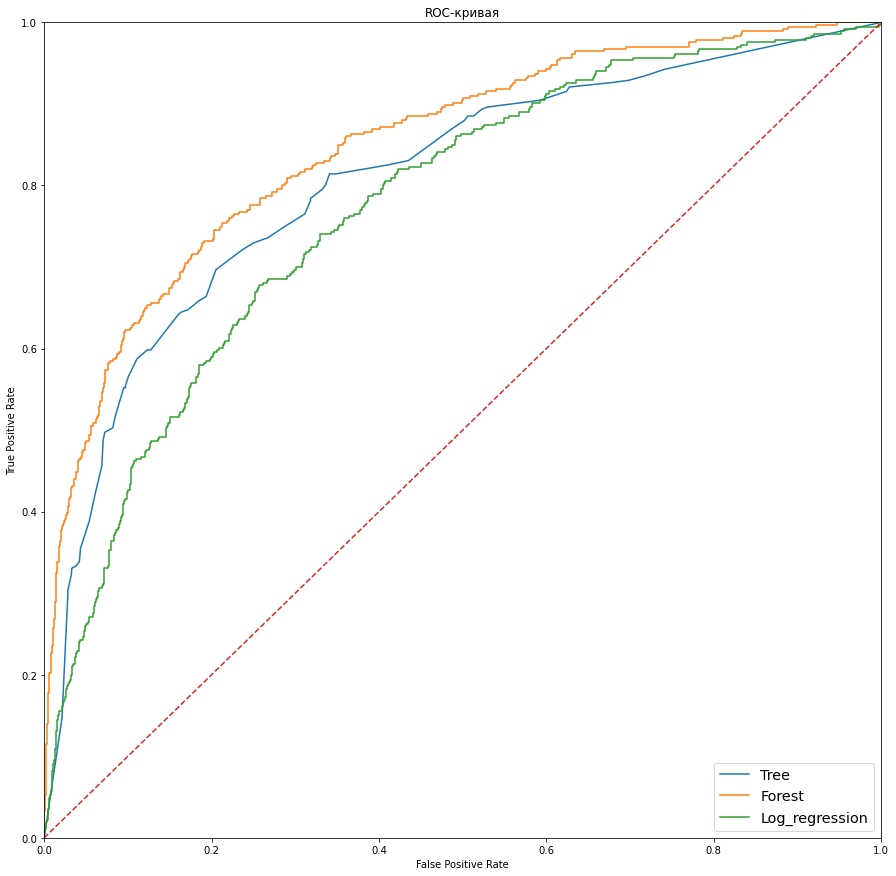

In [16]:
plt.figure(figsize=(15,15))

plt.plot(fpr_tree, tpr_tree, label='Tree')
plt.plot(fpr_for, tpr_for, label='Forest')
plt.plot(fpr_reg, tpr_reg, label='Log_regression')

# ROC-curve of a random model
plt.plot([0, 1], [0, 1], linestyle='--')

# ROC-curve of a random model
plt.xlim([0,1])
plt.ylim([0,1])

# label the axes "False Positive Rate" and "True Positive Rate"
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# add title "ROC curve" with plt.title() function
plt.title('ROC-кривая')

# add a legend
legend = plt.legend(loc='lower right', shadow=False, fontsize='x-large')

plt.show()

Output: <br />
<br />
The decision tree has the best F1 measure, followed by the random forest. <br />
Random Forest has the largest area under the curve, but Decisive Forest comes in second.

# Investigation of models taking into account the imbalance of classes

## Prepare the data in the same way as before, only take into account the imbalance of classes

Divide the samples into sets with features and a target feature

In [17]:
features = df_ohe.drop(['Exited'], axis=1)
target = df_ohe['Exited']

Let's divide the data into three samples: train, validation test in the ratio `3 : 1 : 1`

In [18]:
features_train, features_valid = train_test_split(features, test_size=0.20, random_state=12345)
features_train, features_test = train_test_split(features_train, test_size=0.25, random_state=12345)

target_train, target_valid = train_test_split(target, test_size=0.20, random_state=12345)
target_train, target_test = train_test_split(target_train, test_size=0.25, random_state=12345)

print(features.shape)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(9091, 11)
(5454, 11)
(1819, 11)
(1818, 11)


Let's calculate the imbalance of classes

0    0.796062
1    0.203938
Name: Exited, dtype: float64


<AxesSubplot:>

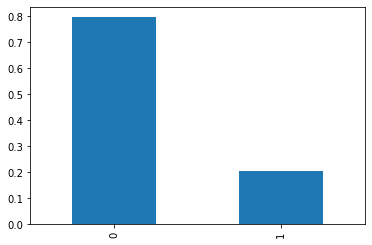

In [19]:
class_frequency = df_ohe['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

We balance the samples by increasing the rare class. It was also possible to balance them by setting the `class_weight='balanced'` parameter when setting up the model.

(4335, 11)
(4476, 11)
1    0.508001
0    0.491999
Name: Exited, dtype: float64


<AxesSubplot:>

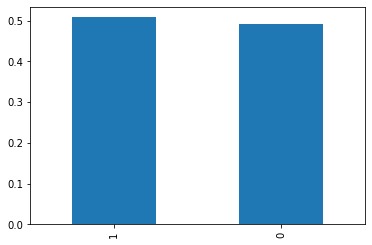

In [20]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

repeat = 4
features_train = pd.concat([features_zeros] + [features_ones] * repeat)
target_train = pd.concat([target_zeros] + [target_ones] * repeat)

shuffle(features_train, random_state=12345)
shuffle(target_train, random_state=12345)

print(features_train[target_train == 0].shape)
print(features_train[target_train == 1].shape)

class_frequency = target_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Scale features

In [21]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## Model: decision tree

In [22]:
for depth in range(1, 12):
    
    model_dec_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_dec_tree.fit(features_train, target_train)
    predicted_valid = model_dec_tree.predict(features_valid)
    
    print('max_depth =', depth)
    print("F1:", f1_score(target_valid, predicted_valid))
    print()

max_depth = 1
F1: 0.4892412231030578

max_depth = 2
F1: 0.5187637969094923

max_depth = 3
F1: 0.5353418308227114

max_depth = 4
F1: 0.4873524451939291

max_depth = 5
F1: 0.5430463576158941

max_depth = 6
F1: 0.5741728922091781

max_depth = 7
F1: 0.5528134254689042

max_depth = 8
F1: 0.5313432835820896

max_depth = 9
F1: 0.5340206185567011

max_depth = 10
F1: 0.5330444203683641

max_depth = 11
F1: 0.5137816979051819



Retrain the model with better parameters

In [23]:
model_dec_tree = DecisionTreeClassifier(random_state=12345, max_depth=6) 
model_dec_tree.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=6, random_state=12345)

## Model: random forest

In [24]:
for est in range(10, 102, 5):
    
    model_ran_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=6)
    model_ran_forest.fit(features_train, target_train)
    predicted_valid = model_ran_forest.predict(features_valid)
    
    print('n_estimators =', est)
    print("F1:", f1_score(target_valid, predicted_valid))
    print()

n_estimators = 10
F1: 0.5977011494252873

n_estimators = 15
F1: 0.6025492468134415

n_estimators = 20
F1: 0.6037296037296037

n_estimators = 25
F1: 0.6034682080924856

n_estimators = 30
F1: 0.608294930875576

n_estimators = 35
F1: 0.6047565118912799

n_estimators = 40
F1: 0.6031746031746031

n_estimators = 45
F1: 0.6073059360730594

n_estimators = 50
F1: 0.6038592508513053

n_estimators = 55
F1: 0.6059225512528473

n_estimators = 60
F1: 0.6056497175141243

n_estimators = 65
F1: 0.6052332195676906

n_estimators = 70
F1: 0.6036446469248292

n_estimators = 75
F1: 0.6075085324232082

n_estimators = 80
F1: 0.6045454545454545

n_estimators = 85
F1: 0.609286523216308

n_estimators = 90
F1: 0.6085972850678734

n_estimators = 95
F1: 0.6122448979591836

n_estimators = 100
F1: 0.609286523216308



Retrain the model with better parameters

In [25]:
model_ran_forest = RandomForestClassifier(random_state=12345, n_estimators=95, max_depth=6)
model_ran_forest.fit(features_train, target_train) 

RandomForestClassifier(max_depth=6, n_estimators=95, random_state=12345)

## Model: logistic regression

In [26]:
model_log_reg = LogisticRegression(random_state=12345, solver='liblinear')
model_log_reg.fit(features_train, target_train)
predicted_valid = model_log_reg.predict(features_valid)
result = model_log_reg.score(features_valid, target_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5090562440419447


## Checking models on a test set

In [27]:
predicted_test = model_dec_tree.predict(features_test)

print("Decision tree model on the test sample:")
print("F1:", f1_score(target_test, predicted_test))

probabilities_test = model_dec_tree.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr_tree, tpr_tree, thresholds_tree = roc_curve(target_test, probabilities_one_test) 
print('auc_roc:', roc_auc_score(target_test, probabilities_one_test))

print()
#//
#//
predicted_test = model_ran_forest.predict(features_test)

print("Random forest model on a test sample:")
print("F1:", f1_score(target_test, predicted_test))

probabilities_test = model_ran_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr_for, tpr_for, thresholds_for = roc_curve(target_test, probabilities_one_test) 
print('auc_roc:', roc_auc_score(target_test, probabilities_one_test))

print()
#//
#//
predicted_test = model_log_reg.predict(features_test)

print("Logistic regression model on a test sample:")
print("F1:", f1_score(target_test, predicted_test))

probabilities_test = model_log_reg.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr_reg, tpr_reg, thresholds_reg = roc_curve(target_test, probabilities_one_test) 
print('auc_roc:', roc_auc_score(target_test, probabilities_one_test))

print()

Модель решающего дерева на тестовой выборке выборке:
F1: 0.5548523206751055
auc_roc: 0.8135151816224842

Модель случайного леса на тестовой выборке выборке:
F1: 0.5903890160183066
auc_roc: 0.8497907540381459

Модель логистической регрессии на тестовой выборке выборке:
F1: 0.4956605593056895
auc_roc: 0.7748329043038432



Let's build the ROC curves of the models and the ROC curve of the random model

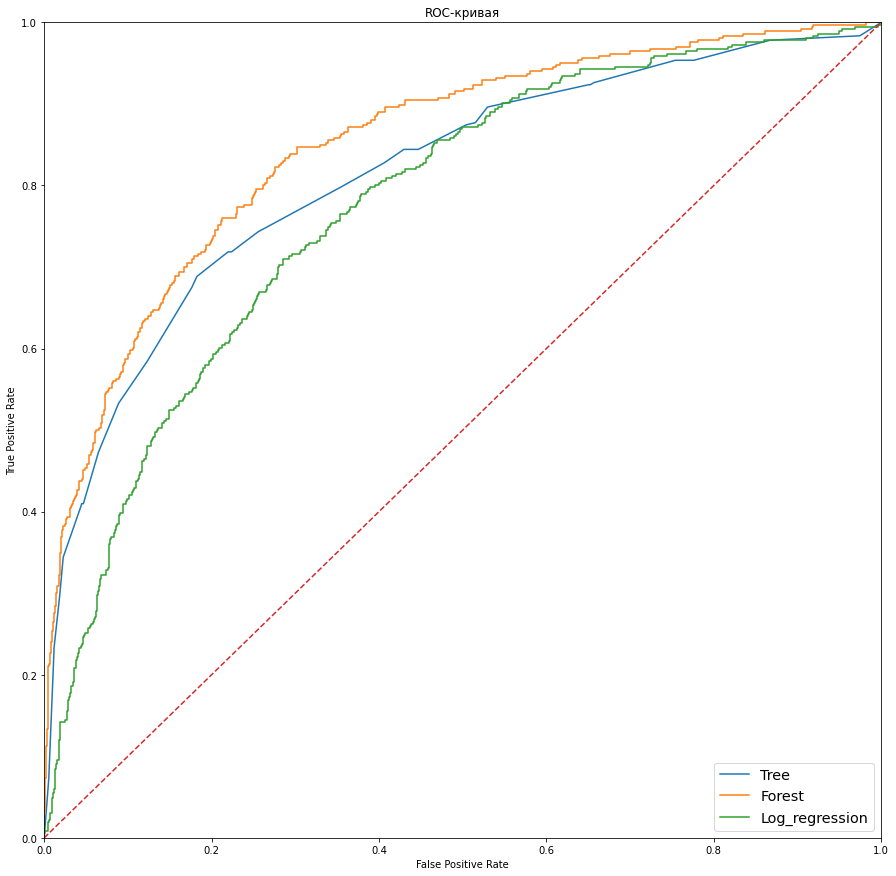

In [28]:
plt.figure(figsize=(15,15))

plt.plot(fpr_tree, tpr_tree, label='Tree')
plt.plot(fpr_for, tpr_for, label='Forest')
plt.plot(fpr_reg, tpr_reg, label='Log_regression')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# установимграницы осей от 0 до 1 >
plt.xlim([0,1])
plt.ylim([0,1])

# подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-curve')

# добавим легенду
legend = plt.legend(loc='lower right', shadow=False, fontsize='x-large')

plt.show()

Output: <br />
<br />
The random forest has the best F1 measure, as does the area under the curve. <br />
Not much, but the decision tree lags behind. <br />
Logistic regression shows the worst results.